In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time

### Load preprocessed dataset

* Download imgcap.zip from LMS
* Unzip
* Upload imgcap.npz, imgcap_output_vocab.json and this template ipynb file

In [3]:
import json

npzfile = np.load("/content/drive/MyDrive/Colab Notebooks/실전딥러닝2023/imgcap.npz")
input_imgs = npzfile['input_imgs']
output_seqs = npzfile['output_seqs']

with open("/content/drive/MyDrive/Colab Notebooks/실전딥러닝2023/imgcap_output_vocab.json", "rb") as f:
    output_vocab = json.load(f)

y_vocab_size = len(output_vocab)
inverse_output_vocab = {index: token for token, index in output_vocab.items()}

input_imgs = np.expand_dims(input_imgs, axis=-1)

In [4]:
input_imgs.shape

(4434, 28, 28, 1)

In [5]:
output_seqs.shape

(4434, 202)

### Check image and caption

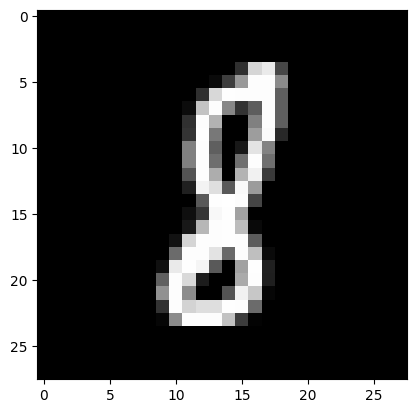

In [6]:
plt.imshow(input_imgs[3931, :, :, 0], cmap='gray')

In [7]:
output_seqs[3931]

array([    1,    79,   408,  2139,    54,    15,  3332,   407,  3001,
         785,   542,     7, 10367,   831,     6,  5250,  1420,    10,
          11,     7,   473,     6,    16,  5425, 10368,    10,   172,
         831,     6,  2670,  1420,    10,    78,   133,    54, 10369,
         232,  1334,  3325,    10,    26,   286,    25,   101,  6906,
           6, 10370,     2,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [8]:

def text_decoding(line, invvocab):
    return [ invvocab[x] for x in line]

In [9]:
print(text_decoding(output_seqs[3931], inverse_output_vocab))

['<bos>', 'this', 'cycle', 'seem', 'to', 'be', 'neither', 'more', 'nor', 'less', 'than', 'the', 'calippic', 'period', 'of', 'seventy-six', 'years', ',', 'with', 'the', 'addition', 'of', 'a', 'greek', 'octaeteris', ',', 'or', 'period', 'of', 'eight', 'years', ',', 'in', 'order', 'to', 'disguise', 'its', 'true', 'source', ',', 'and', 'give', 'it', 'an', 'appearance', 'of', 'originality', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

### Building models

In [10]:
BUFFER_SIZE = len(input_imgs)
BATCH_SIZE = 16
embedding_dim = 1024
latent_dim = 100
output_vocab_size = len(output_vocab)

dataset = tf.data.Dataset.from_tensor_slices((input_imgs, output_seqs)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

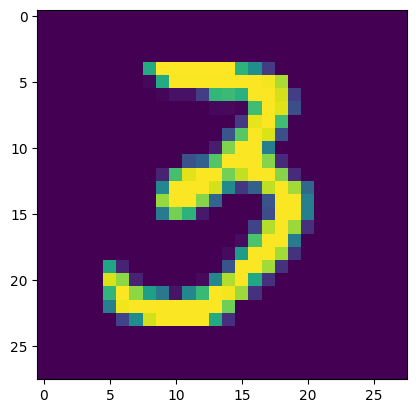

In [11]:
for example_input_batch, example_target_batch in dataset.take(1):
    plt.imshow(example_input_batch[0])
    break

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,MaxPooling2D,UpSampling2D,Flatten,Dense,Reshape



In [48]:
encoder = Sequential([
    Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1), padding="same"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="valid"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    Flatten(),
    Dense(100, activation='relu')  # 출력 차원 조정
])


In [45]:
decoder = Sequential([
    Embedding(output_vocab_size, embedding_dim, input_length=100),
    #Dense(202, activation='relu'),  # 추가된 Dense 레이어
    LSTM(latent_dim, return_sequences=True)
])


In [47]:
def loss(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder = tf.keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss=loss, optimizer=optimizer)

epochs = 1
autoencoder.fit(input_imgs, output_seqs, epochs=epochs, batch_size=BATCH_SIZE)


InvalidArgumentError: ignored

In [41]:
input_imgs[0].shape

(28, 28, 1)

In [43]:
autoencoder.predict(input_imgs)

139/139 [==============================] - 1s 7ms/step


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

### Loss function

In [ ]:
# input your code here

### Training

In [ ]:
# input your code here

### Test translation

In [ ]:
위의 코드를 통해 autoencoder 모델을 훈련시켰다.
i want to show the output sequence with the test images(example_input_batch[0])
Use greedy search for prediction

밑의 코드를 조금 수정해서 beam_translate function을 정의해줘.

beam_translate(tf.expand_dims(example_input_batch[0], axis=0))를 실행하면 output sequence가 출력되도록 해줘 .
example_input_batch[0].shape is  TensorShape([28, 28, 1])
# define beam_translate function
def beam_translate(src,max_steps = 100,k = 16):
  src_tokens = np.array([x_vocab[x] for x in hannanum.morphs(src)])
  src_tokens = np.insert(src_tokens,0,[1])
  src_tokens = np.append(src_tokens,2)
  x_test = tf.expand_dims(src_tokens,axis =0)
  _,s1,s2,s3 = encoder(x_test,training = False)

  last_token = tf.constant([y_vocab['<bos>']])
  candidates = [(0.,tf.expand_dims(last_token,axis = 0),s1,s2,s3,[int(last_token)],False)]

  for _ in range(max_steps):
    new_candidates = []
    for score , token,s1,s2,s3,output_seq,eos in candidates :
      if eos:
        new_candidates.append((score,token,s1,s2,s3,output_seq,eos))
        continue
      logits,s1,s2,s3 = decoder([token,s1,s2,s3],training = False)
      probs = tf.nn.log_softmax(logits,axis =2)
      values, indices = tf.math.top_k(tf.squeeze(probs),k=k)
      for prob, idx in zip(values, indices):
        eos = (int(idx)==y_vocab['<eos>'])
        last_token = tf.constant([int(idx)])
        new_candidates.append(
            (score +float(prob),tf.expand_dims(last_token,axis= 0),s1,s2,s3,
             output_seq + [int(last_token)],eos)
        )
    candidates = sorted(new_candidates, key = lambda t: -t[0])[:k]
  return [(candidates[i][0],' '.join([inverse_y_vocab[x] for x in candidates[i][5]])) for i in range(k)]

In [29]:
def beam_translate(src, max_steps=100, k=16):
  """
  Beam search translation function

  Args:
      src: String input sentence
      max_steps: Maximum number of decoding steps
      k: Beam size

  Returns:
      List of tuples containing (score, translated sentence) for top k candidates
  """

  # Tokenize and prepend/append special tokens
  src_tokens = np.array([x_vocab[x] for x in hannanum.morphs(src)])
  src_tokens = np.insert(src_tokens, 0, [1])
  src_tokens = np.append(src_tokens, 2)
  x_test = tf.expand_dims(src_tokens, axis=0)

  # Encoder inference
  _, s1, s2, s3 = encoder(x_test, training=False)

  # Initialize candidate list with BOS token
  last_token = tf.constant([y_vocab['<bos>']])
  candidates = [(0., tf.expand_dims(last_token, axis=0), s1, s2, s3, [int(last_token)], False)]

  # Decoding loop
  for _ in range(max_steps):
    new_candidates = []
    for score, token, s1, s2, s3, output_seq, eos in candidates:
      if eos:
        new_candidates.append((score, token, s1, s2, s3, output_seq, eos))
        continue

      # Inference with decoder
      logits, s1, s2, s3 = decoder([token, s1, s2, s3], training=False)
      probs = tf.nn.log_softmax(logits, axis=2)

      # Top k candidates with log probabilities
      values, indices = tf.math.top_k(tf.squeeze(probs), k=k)

      for prob, idx in zip(values, indices):
        eos = (int(idx) == y_vocab['<eos>'])
        last_token = tf.constant([int(idx)])

        # Append new candidate with score, token, state, and EOS flag
        new_candidates.append((
            score + float(prob),
            tf.expand_dims(last_token, axis=0),
            s1, s2, s3,
            output_seq + [int(last_token)],
            eos))

    # Sort candidates by score and keep top k
    candidates = sorted(new_candidates, key=lambda t: -t[0])[:k]

  return [(candidates[i][0], ' '.join([inverse_y_vocab[x] for x in candidates[i][5]])) for i in range(k)]


In [30]:
res = beam_translate(tf.expand_dims(example_input_batch[0], axis=0))
res[0]

NameError: ignored

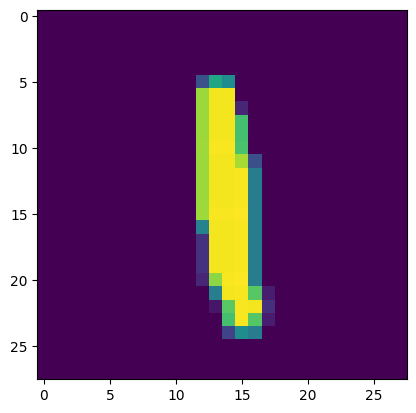

In [28]:
plt.imshow(example_input_batch[1])

In [34]:
tf.expand_dims(example_input_batch[0], axis=0).shape

TensorShape([1, 28, 28, 1])

In [35]:
example_input_batch[0].shape

TensorShape([28, 28, 1])

In [36]:
def beam_translate(src, max_steps=100, k=16):
  """
  Beam search translation function

  Args:
      src: String input sentence
      max_steps: Maximum number of decoding steps
      k: Beam size

  Returns:
      List of tuples containing (score, translated sentence) for top k candidates
  """

  # Encoder inference
  _, s1, s2, s3 = encoder(src, training=False)

  # Initialize candidate list with BOS token
  last_token = tf.constant([y_vocab['<bos>']])
  candidates = [(0., tf.expand_dims(last_token, axis=0), s1, s2, s3, [int(last_token)], False)]

  # Decoding loop
  for _ in range(max_steps):
    new_candidates = []
    for score, token, s1, s2, s3, output_seq, eos in candidates:
      if eos:
        new_candidates.append((score, token, s1, s2, s3, output_seq, eos))
        continue

      # Inference with decoder
      logits, s1, s2, s3 = decoder([token, s1, s2, s3], training=False)
      probs = tf.nn.log_softmax(logits, axis=2)

      # Top k candidates with log probabilities
      values, indices = tf.math.top_k(tf.squeeze(probs), k=k)

      for prob, idx in zip(values, indices):
        eos = (int(idx) == y_vocab['<eos>'])
        last_token = tf.constant([int(idx)])

        # Append new candidate with score, token, state, and EOS flag
        new_candidates.append((
            score + float(prob),
            tf.expand_dims(last_token, axis=0),
            s1, s2, s3,
            output_seq + [int(last_token)],
            eos))

    # Sort candidates by score and keep top k
    candidates = sorted(new_candidates, key=lambda t: -t[0])[:k]

  return [(candidates[i][0], ' '.join([inverse_y_vocab[x] for x in candidates[i][5]])) for i in range(k)]
res = beam_translate(tf.expand_dims(example_input_batch[0], axis=0))
res[0]

ValueError: ignored

In [ ]:
#define encoder layers
conv1 = Conv2D(6,kernel_size = (5,5),strides=(1,1),activation ='relu',
                 input_shape = (28,28,1),padding = "same")
maxpool1 = MaxPooling2D(pool_size =(2,2),strides = (2,2),padding = 'valid')

conv2 = Conv2D(16,kernel_size = (5,5),strides=(1,1),activation ='relu',
                 padding = "valid")
maxpool2 = MaxPooling2D(pool_size =(2,2),strides = (2,2),padding = 'valid')
flat = Flatten()
dense = Dense(100, activation = 'relu')

#define decoder layers
#The decoder of Seq2Seq implementation